### Read libraries.



In [107]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
#import phase_portraits as pp
#from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets#
import ipywidgets as widgets
import pandas as pd
from IPython.display import Image
import seaborn as sns
import scipy.stats as stats
from scipy.integrate import odeint
import pymc as pm
import arviz as az
from scipy.interpolate import interp1d

%matplotlib inline

## SIRS modellen

We are going to look at the following SIRS modell with vaccination:
$$
\begin{array}{rl}
\displaystyle\frac{dS}{dt}  & = -  \beta I S + \delta R \\[5mm]
\displaystyle\frac{dI}{dt}  & =  \beta I S - \gamma I  \\[5mm]
\displaystyle\frac{dR}{dt}  & = \gamma I -\delta R  \nonumber
\end{array}
$$

This is an example of a compartment model, simulating how people are moving from one compartment to the other. When susceptible, $S$, meet infected $I$ they have a certain probability of being infected. After a while the infected recover, entering the $R$ compartment. In this model the recovered are again transferred back to the $S$ compartment, they are only immune for a certain amount of time. In the model we can also have an arrow bringing individuals from $S$ to $R$ directly, assuming that the vaccination is only efficient for the same time as for the individual recovered after an infection. The vaccination effort, denoted $V$ in the figure. We're later going to assume that $V$ is either a constant, i.e. a continuous vaccination program, or proportional to the infection level, i.e. reaction to an outbreak.

where $S$, $I$ and $R$ are, respectively, the fraction of the population that are susceptible, infected, and recovered. This is an example of a compartment model, simulating how people are moving from one compartment to the other. When susceptible, $S$, meet infected *I* they have a certain probability of being infected. *V* represent vaccination, i.e. moving individuals directly from *S* to *R*. 








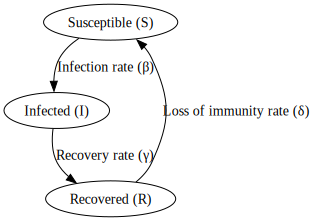

In [77]:
from graphviz import Digraph
from IPython.display import display

dot = Digraph()

# Nodes
dot.node('S', 'Susceptible (S)', pos='0,1!')
dot.node('I', 'Infected (I)', pos='1,0!')
dot.node('R', 'Recovered (R)', pos='0,-1!')

# Edges
dot.edge('S', 'I', label='Infection rate (β)')
dot.edge('I', 'R', label='Recovery rate (γ)')
dot.edge('R', 'S', label='Loss of immunity rate (δ)')

# Set graph attributes for circular layout
dot.attr(overlap='false')
dot.attr(splines='true')

# Display the graph inline
display(dot)


We will for the moment work with an non-dimensional version of the model. Introducing a charactiristic time scale to 1/$\gamma$, i.e. the average recovery time. So $t=\tau \gamma$ our new model equations become
$$
\begin{array}{rl}
\displaystyle\frac{dS}{d\tau}  & = -  R_m I S + \Delta R \\[5mm]
\displaystyle\frac{dI}{d\tau}  & =  R_m I S -  I  \\[5mm]
\displaystyle\frac{dR}{d\tau}  & =  I -\Delta R  \nonumber
\end{array}
$$
In the figure that follows, we have that $S+I+R=1$, and the _time_ has unit of how long infected people stay sick. 

In [78]:
# The SIRS model differential equations.

days = range(0, 40)

def deriv(state, t, R0, Delta):
    S, I, R = state
    # Change in S population over time
    dSdt = - R0 * S * I + Delta*R
    # Change in I population over time
    dIdt = R0 * S * I -  I
    # Change in R population over time
    dRdt =   I - Delta*R
    return dSdt, dIdt, dRdt


#mylayout =Layout(width='10cm')

def g(time,Delta,R0):
    init=[0.99,0.01,0]
    days=np.linspace(0, time,num=10*time)
    ret = odeint(deriv, init,
             days,
             args=(R0 ,Delta))

    S, I, R = ret.T

    df = pd.DataFrame({
    'susceptible': S,
    'infectious': I,
    'recovered': R,
    'time': days})

    # Create figures
    fig=plt.figure()
    fig.tight_layout(pad=6.0)
    ax_upper = plt.subplot2grid((2, 2), (0, 0), colspan=2)

    ax_lower_left = plt.subplot2grid((2, 2), (1, 0))
    ax_lower_right = plt.subplot2grid((2, 2), (1, 1))
    plt.subplots_adjust(hspace=0.5)
    df.plot(x='time',
            y=['infectious', 'susceptible', 'recovered'],
            color=['#bb6424', '#aac6ca', '#cc8ac0'],
            ax=ax_upper )
    
    df.plot(x='susceptible',
            y=['infectious'],
            color=['#bb6424'],
            ax=ax_lower_left )
    df.plot(x='susceptible',
            y=[ 'recovered'],
            color=['#cc8ac0'],
            ax=ax_lower_right )
    ax_lower_right.set_ybound(0,1.)
    ax_lower_left.set_ybound(0,1.)
    
    plt.show()

    print('max number of infected =',np.max(I));


interact(g, 
            time=widgets.Dropdown(
                options=[10,40, 100, 160],
                value=10,
                description='end time:',
                disabled=False,),
            Delta=widgets.Dropdown(
                options=[0., 0.01, 0.02, 0.05, 0.1,0.5,1.],
                value=0.,
                description='Delta:',
                disabled=False,),
             R0=widgets.FloatSlider(min=0.5, max=10., step=0.1, value=3.8, description='R0:',
                                  continuous_update=False,readout=True, readout_format='.1f'));



interactive(children=(Dropdown(description='end time:', options=(10, 40, 100, 160), value=10), Dropdown(descri…

Remember, as long as $\Delta$ (Delta) is equal to zero, we have a regular SIR model. Once recovered you will stay immune for all eternity. Once we give a positive value to $\Delta$, we will be moved back into the $S$ compartment after a while, and can get sick again. 

Try the following: 
- As usuall, higher $R_0$ means earlier peak and the maximum number of infected at any time is higher. 
- Set $Delta$ to 0.01, the recovered individuals will be transfered back to S and we get a second peak. Remember to set the end time to a larger value to see it. 



## Sannsynlighetsfordelinger

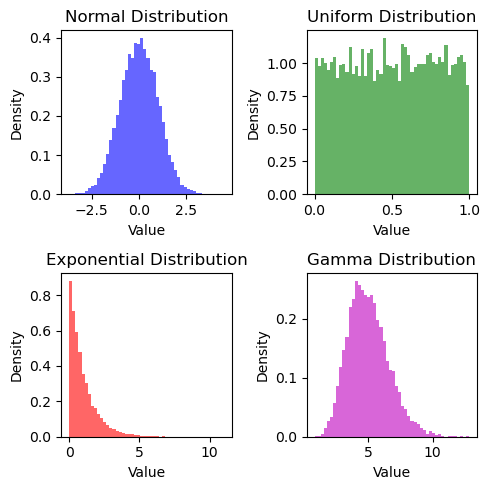

In [101]:

# Number of samples
num_samples = 10000

# Generate samples from different distributions
normal_samples = np.random.normal(loc=0, scale=1, size=num_samples)
uniform_samples = np.random.uniform(low=0, high=1, size=num_samples)
exponential_samples = np.random.exponential(scale=1, size=num_samples)
gamma_samples = np.random.gamma(shape=10, scale=0.5, size=num_samples)

# Plot the distributions
plt.figure(figsize=(5, 5))

# Normal Distribution
plt.subplot(2, 2, 1)
plt.hist(normal_samples, bins=50, density=True, alpha=0.6, color='b')
plt.title('Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

# Uniform Distribution
plt.subplot(2, 2, 2)
plt.hist(uniform_samples, bins=50, density=True, alpha=0.6, color='g')
plt.title('Uniform Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

# Exponential Distribution
plt.subplot(2, 2, 3)
plt.hist(exponential_samples, bins=50, density=True, alpha=0.6, color='r')
plt.title('Exponential Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

# Gamma Distribution
plt.subplot(2, 2, 4)
plt.hist(gamma_samples, bins=50, density=True, alpha=0.6, color='m')
plt.title('Gamma Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


## Usikkerhet i parameter
Anta a parametrene i SIR modellen vår følger normalfordelinger: 
$$
\beta \sim N(\overline{\beta},\sigma_\beta) \\
\gamma \sim N(\overline{\gamma},\sigma_\gamma)
$$
I SIR modeller er $R_0$ tallet

$$
 R_0 = \frac{\beta}{\gamma}.
$$
Vi kan finne en fordeling på $R_0$ ved å bruke MCMC:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, gamma]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


R test for distribusjon:
('lognorm', (0.2424362487838171, -0.80488333180763, 2.8086652052159575), {'norm': 0.05912247645854196, 'expon': 0.371618843275338, 'lognorm': 0.01436640561355379, 'gamma': 0.019054347744349887, 'weibull_min': 0.06153087605478415})



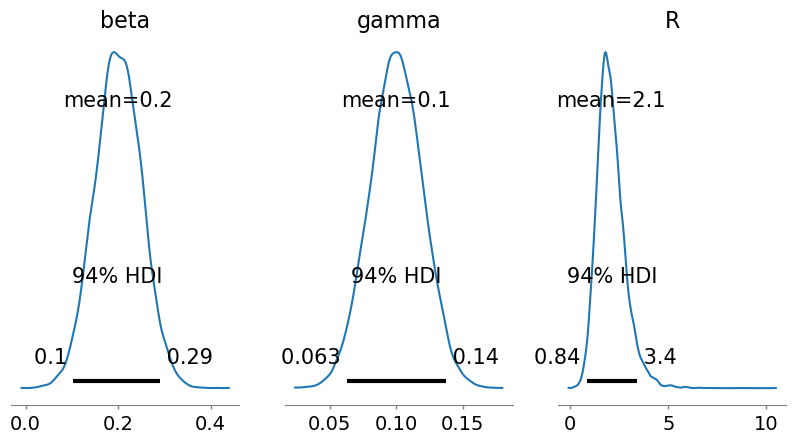

In [81]:

def test_distributions(data):
# Test which distribution that is closest to the data. 
    distributions = ['norm', 'expon', 'lognorm', 'gamma', 'weibull_min']
    results = {}
    params_dict = {}

    for distribution in distributions:
        dist = getattr(stats, distribution)
        params = dist.fit(data)
        ks_stat, p_value = stats.kstest(data, distribution, args=params)
        results[distribution] = ks_stat
        params_dict[distribution] = params

    closest_distribution = min(results, key=results.get)
    return closest_distribution, params_dict[closest_distribution], results




def plot_distribution(data, distribution, params):
    # Generate the PDF values
    x = np.linspace(min(data), max(data), 100)
    dist = getattr(stats, distribution)
    pdf_values = dist.pdf(x, *params)

    # Plot the normalized histogram and the PDF
    plt.hist(data, bins=40, density=True, alpha=0.6, color='g', label='Data')
    plt.plot(x, pdf_values, label=f'{distribution} PDF')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(f'Normalized Histogram and {distribution} PDF')
    plt.legend()
    plt.show()

# Parameters for the normal distributions
beta_mean = 0.2
beta_std = 0.05
gamma_mean = 0.1
gamma_std = 0.02

# Define the PyMC model
with pm.Model() as model:
    # Priors for beta and gamma
    beta = pm.Normal('beta', mu=beta_mean, sigma=beta_std)
    gamma = pm.Normal('gamma', mu=gamma_mean, sigma=gamma_std)
    
    # Deterministic transformation for R
    R = pm.Deterministic('R', beta / gamma)
    
    # Sample from the posterior
    trace = pm.sample(5000, tune=1000, progressbar=False, return_inferencedata=True)

print('R test for distribusjon:')
print(test_distributions(trace.posterior.R.values.flatten()))
print()
fig,axs = plt.subplots(1,3)
fig.set_figwidth(10)
az.plot_posterior(trace, var_names=['beta'],ax=axs[0])
az.plot_posterior(trace, var_names=['gamma'],ax=axs[1])
# Plot the posterior distribution of R
az.plot_posterior(trace, var_names=['R'],ax=axs[2])
plt.show()





In [91]:

closest_distribution, params_dict, results=test_distributions(trace.posterior.R.values.flatten())
print('R test for distribusjon:')
print(closest_distribution, params_dict)
print(results)
print()

R test for distribusjon:
lognorm (0.2424362487838171, -0.80488333180763, 2.8086652052159575)
{'norm': 0.05912247645854196, 'expon': 0.371618843275338, 'lognorm': 0.01436640561355379, 'gamma': 0.019054347744349887, 'weibull_min': 0.06153087605478415}



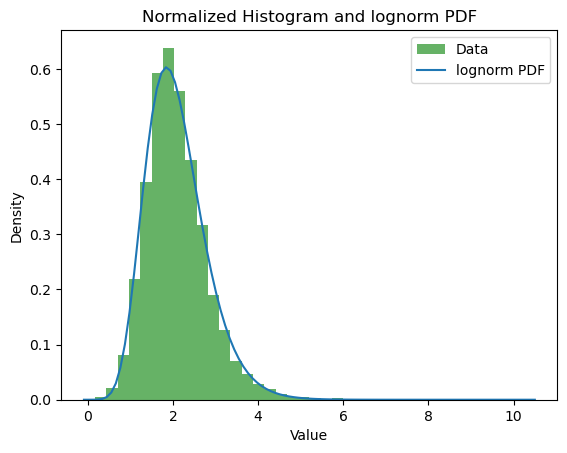

In [84]:
plot_distribution(trace.posterior.R.values.flatten(), closest_distribution, params_dict)

## SIR model med usikkerhet

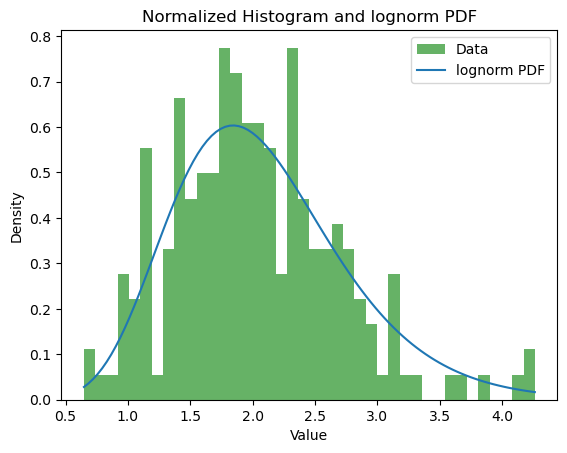

In [94]:
def draw_samples(distribution_name, params, size=100):
    # Draw samples from the specified distribution with given parameters.
    dist = getattr(stats, distribution_name)
    samples = dist.rvs(*params[:-2], loc=params[-2], scale=params[-1], size=size)
    return samples
dist = draw_samples(closest_distribution,params_dict,size=200)
plot_distribution(dist, closest_distribution, params_dict)


In [100]:
# The SIRS model differential equations.



def deriv(state, t, R0, Delta):
    S, I, R = state
    # Change in S population over time
    dSdt = - R0 * S * I + Delta*R
    # Change in I population over time
    dIdt = R0 * S * I -  I
    # Change in R population over time
    dRdt =   I - Delta*R
    return dSdt, dIdt, dRdt


#mylayout =Layout(width='10cm')

def g(time,Delta,R0_mn,R0_sd):
    num_simulations=100
    init=[0.99,0.01,0]
    days=np.linspace(0, time,num=10*time)
    results = []
    for _ in range(num_simulations):
    # Draw R_0 from Gaussian distributions
        R0 = np.random.normal(R0_mn, R0_sd)
        ret = odeint(deriv, init,
             days,
             args=(R0 ,Delta))
        
        results.append(ret)
    # Solve ODE

    
    results = np.array(results)




    # Create figures
    fig=plt.figure()
    fig.tight_layout(pad=6.0)
    ax_upper = plt.subplot2grid((2, 2), (0, 0), colspan=2)

    ax_lower_left = plt.subplot2grid((2, 2), (1, 0))
    ax_lower_right = plt.subplot2grid((2, 2), (1, 1))
    plt.subplots_adjust(hspace=0.5)
    for result in results:
        
        S, I, R = result.T
        
        ax_upper.plot(days, S, color='#aac6ca', alpha=0.1)
        ax_upper.plot(days, I, color='#bb6424', alpha=0.1)
        ax_upper.plot(days, R, color='#cc8ac0', alpha=0.1)

        ax_lower_left.plot(S, I, color='#bb6424', alpha=0.1)
        ax_lower_right.plot(S, R, color='#cc8ac0', alpha=0.1)

    
    ax_lower_right.set_ybound(0,1.)
    ax_lower_left.set_ybound(0,1.)
    
    plt.show()

    


interact(g, 
            time=widgets.Dropdown(
                options=[10,40, 100, 160],
                value=10,
                description='time:',
                disabled=False,),
            Delta=widgets.Dropdown(
                options=[0., 0.01, 0.02, 0.05, 0.1,0.5,1.],
                value=0.,
                description='Delta:',
                disabled=False,),
            R0_mn=widgets.FloatSlider(min=0.5, max=10., step=0.1, value=3.8, description='R0 mean:',
                                  continuous_update=False,readout=True, readout_format='.1f'),
            R0_sd=widgets.FloatSlider(min=0., max=1., step=0.1, value=0.1, description='R0 std:',
                                  continuous_update=False,readout=True, readout_format='.1f'));



interactive(children=(Dropdown(description='time:', options=(10, 40, 100, 160), value=10), Dropdown(descriptio…

## Time varying R

In [142]:
R_t_all = pd.read_csv('R_estimate.csv')
R_t=R_t_all['R_t']
R_t.index.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [143]:
R_t_all

,date,n_pos,R_t
0,2020-04-14,94.714286,0.905070
1,2020-04-15,94.285714,0.944720
2,2020-04-16,91.000000,0.950222
3,2020-04-17,96.714286,1.041522
4,2020-04-18,88.000000,0.963886
...,...,...,...
939,2022-11-09,129.428571,1.060642
940,2022-11-10,126.714286,1.031899
941,2022-11-11,121.571429,0.988420
942,2022-11-12,117.285714,0.961403


In [ ]:
R

In [113]:
f_R = interp1d(R_t.index.values, R_t.values)


array(0.90507003)

In [150]:
# The SIRS model differential equations.



def deriv(state, t):
    S, I, R = state
    R_of_t=f_R(t)
    Delta=0
    gamma=0.1
    beta=gamma*R_of_t
    # Change in S population over time
    dSdt = - beta  *S * I + Delta*R
    # Change in I population over time
    dIdt = beta * S * I -  beta*I
    # Change in R population over time
    dRdt =   beta*I - Delta*R
    return dSdt, dIdt, dRdt


#mylayout =Layout(width='10cm')
time=100
init=[0.95,0.05,0]
days=np.linspace(0, time,num=10*time)


        
ret = odeint(deriv, init,
             days)
        





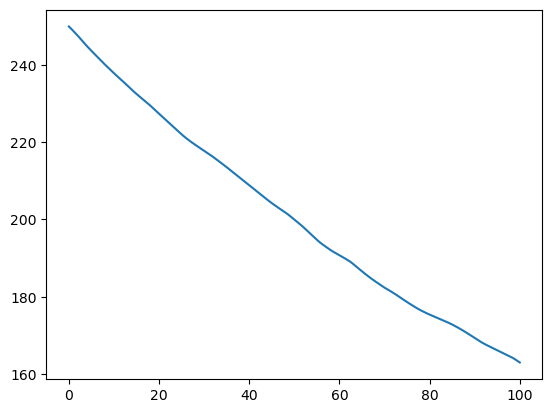

In [151]:
plt.plot(days,I*5000)

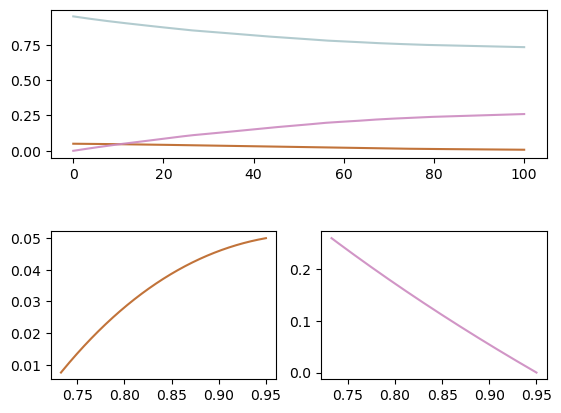

In [152]:
S, I, R = ret.T

# Create figures
fig=plt.figure()
fig.tight_layout(pad=6.0)
ax_upper = plt.subplot2grid((2, 2), (0, 0), colspan=2)

ax_lower_left = plt.subplot2grid((2, 2), (1, 0))
ax_lower_right = plt.subplot2grid((2, 2), (1, 1))
plt.subplots_adjust(hspace=0.5)
        

ax_upper.plot(days, S, color='#aac6ca', alpha=0.9)
ax_upper.plot(days, I, color='#bb6424', alpha=0.9)
ax_upper.plot(days, R, color='#cc8ac0', alpha=0.9)

ax_lower_left.plot(S, I, color='#bb6424', alpha=0.9)
ax_lower_right.plot(S, R, color='#cc8ac0', alpha=0.9)

#ax_lower_right.set_ybound(0,1.)
#ax_lower_left.set_ybound(0,1.)
    
plt.show()

    



